# Normalizing Flows with Dr.Jit

In this tutorial, we will implement normalizing flows using the Dr.Jit compiler.
Normalizing flows are a powerful class of generative models that learn complex
probability distributions by transforming a simple base distribution through a
series of invertible transformations. Unlike GANs and VAEs, normalizing flows
provide exact likelihood computation and invertible sampling, making them
particularly useful for density estimation, generative modeling, and Bayesian
inference in computer graphics applications.

## Key Advantages of Normalizing Flows:
- **Exact likelihood computation**: Direct evaluation of $p(x)$ without approximations
- **Invertible transformations**: Bidirectional mapping between data and latent space
- **Tractable sampling**: Generate new samples by transforming noise through learned mappings
- **Applications in graphics**: Neural BRDFs, importance sampling, and scene rendering

## Imports

In [1]:
from pathlib import Path
from typing import Literal
import imageio.v3 as iio
import tqdm
import matplotlib.pyplot as plt
import numpy as np

import drjit as dr
import drjit.nn as nn
from drjit.opt import Adam, GradScaler
from drjit.auto.ad import (
    Texture2f,
    TensorXf,
    TensorXf16,
    Float16,
    Float32,
    ArrayXf16,
    Array2f,
    Array3f,
)

## Random Number Generation

We initialize a random number generator that serves as the source of randomness
throughout this tutorial. Dr.Jit's random number generator ensures proper
statistical independence between samples, which is crucial for training
stability and preventing correlation artifacts in the learned distributions.

In [2]:

rng = dr.rng(seed=0)

## Base Distribution

Normalizing flows require a simple base distribution $p_Z(z)$ from which we can
easily sample and evaluate densities. We use a standard multivariate normal
distribution $\mathcal{N}(0, I)$ as our base distribution.

Since Dr.Jit's random number generator produces uniformly distributed values
$U \sim \text{Uniform}(0,1)$, we transform them to Gaussian samples using the
Box-Muller transform:
$$z_1 = \sqrt{-2\ln(u_1)} \cos(2\pi u_2)$$
$$z_2 = \sqrt{-2\ln(u_1)} \sin(2\pi u_2)$$

We also need to evaluate $\log p_Z(z)$ for the standard normal distribution:
$$\log p_Z(z) = -\frac{1}{2}\log(2\pi) - \frac{1}{2}z^2$$

In [3]:


def square_to_std_normal(sample: Array2f):
    """
    Transform uniform samples to standard normal using Box-Muller transform.

    Args:
        sample: 2D uniform samples from [0,1)²

    Returns:
        2D samples from standard normal distribution N(0,1)
    """
    r = dr.sqrt(-2.0 * dr.log(1.0 - sample[0]))
    phi = 2.0 * dr.pi * sample[1]

    s, c = dr.sincos(phi)
    return Array2f(c * r, s * r)


def log_std_normal_pdf(z: dr.ArrayBase):
    """
    Evaluate log probability density of standard normal distribution.

    For a d-dimensional standard normal: log p(z) = -d/2 * log(2π) - 1/2 * ||z||²
    """
    return -dr.log(dr.two_pi) - 0.5 * dr.square(z)

## Reference Distribution

To train a normalizing flow, we need a target distribution $\hat{p}_X(x)$ that
we want to learn. This represents the "true" data distribution we're trying to
model. In practice, this could be:
- Empirical data distribution (images, audio, etc.)
- Known analytical distributions for validation
- Complex synthetic distributions for testing

We define a `Distr2D` interface for 2D distributions that can generate samples.

In [4]:


class Distr2D:
    def sample(
        self,
        rng: dr.random.Generator,
        n: int,
    ) -> Array2f: ...


class SpiralDistr(Distr2D):
    """
    Double spiral distribution for testing normalizing flows.

    Generates samples following two interleaved spiral arms with added noise.
    This creates a complex, multimodal target distribution that tests the
    flow's ability to learn intricate geometric structures.
    """

    def __init__(self) -> None: ...
    def sample(
        self,
        rng: dr.random.Generator,
        n: int,
    ) -> Array2f:
        sample1 = rng.random(Float32, n)
        sample2 = rng.random(Array2f, (2, n))

        # Transform uniform [0,1] to [-1,1] and create spiral parameter
        sample1 = sample1 * 2 - 1
        t = dr.sqrt(dr.abs(sample1))  # Spiral parameter
        r = t * 4 * dr.sign(sample1)  # Radius with alternating signs for double spiral
        phi = t * dr.two_pi * 1.5  # Angular component

        s, c = dr.sincos(phi)
        x = Array2f(c * r, s * r)  # Spiral coordinates
        y = square_to_std_normal(sample2) * 0.15  # Gaussian noise

        return x + y  # Noisy spiral samples

It is also possible to sample values according to an arbitrary distribution,
which we can define using an image. To use this distribution, Mitsuba 3 must
be installed, which provides an implementation of a fast discrete
distribution.

In [5]:


class ImageDistr(Distr2D):
    """
    Image-based distribution using pixel intensities as probability densities.

    This distribution treats image pixels as a discrete 2D probability mass
    function, enabling the modeling of arbitrary shapes and patterns defined
    by images. Useful for testing flows on complex, real-world-like distributions.

    Requires Mitsuba 3 for efficient discrete distribution sampling.
    """

    def __init__(
        self,
        uri: str = "data/albert.jpg",
    ) -> None:
        import mitsuba as mi

        mi.set_variant("cuda_ad_rgb", "llvm_ad_rgb")

        self.mi = mi

        # Load and preprocess image
        img = iio.imread(uri)
        if len(img.shape) == 3:  # Convert RGB to grayscale
            img = img.mean(-1)
        img = img / img.sum(None)  # Normalize to probability distribution
        self.shape = img.shape

        # Create discrete 2D distribution from image
        distr = mi.DiscreteDistribution2D(img)
        self.distr = distr

    def sample(
        self,
        rng: dr.random.Generator,
        n: int,
    ) -> Array2f:
        """
        Sample points according to image-defined probability density.

        The image intensities define relative probabilities, with brighter
        pixels having higher sampling probability. Coordinates are normalized
        to the [-4, 4]² range for consistency with other distributions.

        Args:
            rng: Random number generator
            n: Number of samples to generate

        Returns:
            2D coordinates sampled according to image density
        """
        mi = self.mi
        x, _, _ = self.distr.sample(rng.random(mi.Point2f, (2, n)))
        m = max(self.shape[0], self.shape[1])
        x = mi.Point2f(x) / mi.Vector2f(m)
        x = mi.Point2f(x.x, 1.0 - x.y)
        return Array2f(x * 8 - 4)


# Choose reference distribution for training
# - SpiralDistr: Double spiral pattern (good for testing)
# - ImageDistr: Custom image-based distribution (requires Mitsuba 3)
ref = SpiralDistr()
# ref = ImageDistr()  # Uncomment to use image-based distribution

To visualize the distribution, we define a function, which plots the
histograms of samples from said distribution.

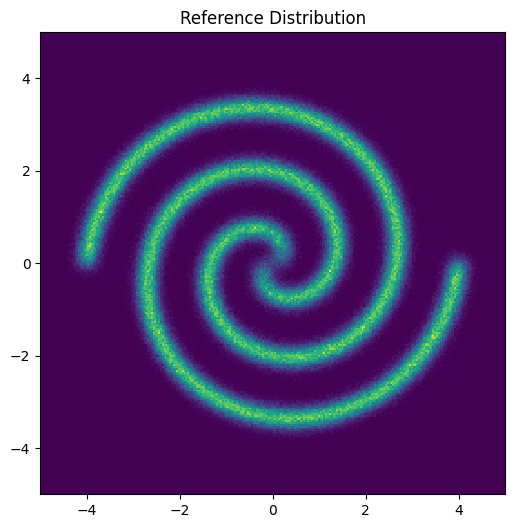

In [6]:


def plot_hist(*distrs: tuple[str, Distr2D]):
    """
    Visualize 2D distributions using histograms.

    Creates side-by-side 2D histograms for comparing different distributions.
    Useful for visualizing the learning progress and quality of the flow model.

    Args:
        *distrs: Variable number of (name, distribution) tuples to plot
    """
    n = len(distrs)
    n_bins = 256
    hist_range = [[-5, 5], [-5, 5]]
    fig, ax = plt.subplots(1, n, figsize=(6 * n, 6))
    ax = [ax] if n == 1 else ax
    for i in range(n):
        name, dist = distrs[i]
        x = dist.sample(rng, 1_000_000)
        ax[i].hist2d(x[0], x[1], bins=n_bins, range=hist_range)
        ax[i].set_title(name)


# Visualize the reference distribution
plot_hist(("Reference Distribution", ref))

## Activation Functions

We implement the Gaussian Error Linear Unit (GELU) activation function,
which is not available in Dr.Jit's neural network module. GELU is defined as:
$$\text{GELU}(x) = x \cdot \Phi(x) = x \cdot \frac{1}{2}\left[1 + \text{erf}\left(\frac{x}{\sqrt{2}}\right)\right]$$

GELU provides smooth, non-monotonic activation that works well for normalizing
flows. We provide both exact and tanh approximation implementations:
- **Exact**: Uses the error function `erf(x)`
- **Tanh approximation**: $\text{GELU}(x) \approx 0.5x\left[1 + \tanh\left(\sqrt{\frac{2}{\pi}}(x + 0.044715x^3)\right)\right]$

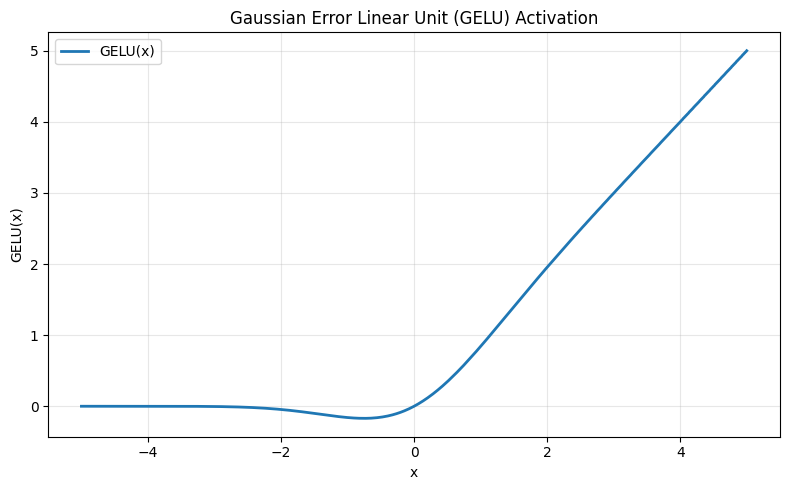

In [7]:


class GELU(nn.Module):
    r"""
    Gaussian Error Linear Unit activation function.

    GELU provides a smooth approximation to the ReLU activation that has shown
    superior performance in many deep learning applications. Unlike ReLU, GELU
    is differentiable everywhere and provides non-zero gradients for negative inputs.

    Args:
        approx: Approximation method - "none" for exact, "tanh" for fast approximation
    """

    DRJIT_STRUCT = {"approx": str}

    def __init__(self, approx: Literal["none", "tanh"] = "none") -> None:
        super().__init__()
        self.approx = approx

    def __call__(self, arg: nn.CoopVec, /) -> nn.CoopVec:
        if self.approx == "tanh":
            return (
                0.5
                * arg
                * (1 + dr.tanh(dr.sqrt(2 / dr.pi) * (arg + 0.044715 * arg * arg * arg)))
            )
        elif self.approx == "none":
            x = ArrayXf16(arg)
            y = x * (1 + dr.erf(x))
            return nn.CoopVec(y)


# Visualize GELU activation function
x = dr.linspace(Float32, -5, 5, 1000)
y = ArrayXf16(GELU("tanh")(x))
plt.figure(figsize=(8, 5))
plt.plot(x, y, linewidth=2, label="GELU(x)")
plt.xlabel("x")
plt.ylabel("GELU(x)")
plt.title("Gaussian Error Linear Unit (GELU) Activation")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

## Dimension Alignment Layer

Dr.Jit's CUDA backend requires tensor dimensions to be even for matrix
multiplications. Since coupling layers process half the input dimensions
(which may be odd), we implement a `TwoAlign` layer that pads the dimension
count to ensure even-sized tensors.

This is a technical detail for GPU compatibility and doesn't affect the
mathematical properties of the flow.

In [8]:


class TwoAlign(nn.Module):
    r"""
    Dimension alignment layer for CUDA compatibility.

    Ensures the output dimension count is even by adding a zero-valued
    component if necessary. This enables efficient GPU execution without
    affecting the mathematical properties of the transformation.
    """

    DRJIT_STRUCT = {}

    def _alloc(
        self, dtype: type[dr.ArrayBase], size: int, rng: dr.random.Generator, /
    ) -> tuple[nn.Module, int]:
        return self, size if size % 2 == 0 else size + 1

    def __call__(self, arg: nn.CoopVec, /) -> nn.CoopVec:
        tp = arg.type
        arg = list(arg)
        if len(arg) % 2 != 0:
            arg.append(tp(0))
        return nn.CoopVec(*arg)

## Normalizing Flows Theory

Normalizing flows are generative models that learn complex probability distributions
through a series of invertible transformations. They provide exact likelihood
computation and efficient sampling, making them invaluable for applications
requiring both properties simultaneously.

### Mathematical Foundation

A normalizing flow consists of:
- **Base distribution**: Simple distribution $p_Z(z)$ (typically $\mathcal{N}(0,I)$)
- **Invertible transformation**: Bijective function $f_\theta: \mathbb{R}^d \to \mathbb{R}^d$
- **Target distribution**: Complex learned distribution $p_{X;\theta}(x)$

The transformation relates these via the change of variables formula:
$$p_{X;\theta}(x) = p_Z(f_\theta(x)) \left|\det \frac{\partial f_\theta}{\partial x}\right|$$

### Forward and Inverse Operations

- **Sampling**: $x = f_\theta^{-1}(z)$ where $z \sim p_Z$
- **Density evaluation**: $\log p_{X;\theta}(x) = \log p_Z(z) + \log\left|\det J_{f_\theta}\right|$

where $z = f_\theta(x)$ and $J_{f_\theta}$ is the Jacobian of the transformation.

### Composition of Layers

Complex flows are built by composing simple invertible layers:
$$f_\theta = f_K \circ f_{K-1} \circ \ldots \circ f_1$$

The log-determinant decomposes as:
$$\log\left|\det J_{f_\theta}\right| = \sum_{k=1}^K \log\left|\det J_{f_k}\right|$$

### Training Objective

We maximize the log-likelihood on training data:
$$\mathcal{L}(\theta) = \mathbb{E}_{x \sim \hat{p}_X}\left[\log p_{X;\theta}(x)\right]$$

### Coupling and Permutation Layers

We use two types of layers:
- **Coupling layers**: Apply element-wise affine transformations to half the dimensions
- **Permutation layers**: Reorder dimensions to enable mixing between coupling layers

This combination ensures the flow can model complex dependencies while maintaining
computational efficiency.

In [9]:


class FlowLayer(nn.Module):
    """
    Abstract base class for normalizing flow layers.

    Each layer must implement:
    - forward: x -> z with log-determinant computation
    - inverse: z -> x for sampling
    """

    def __init__(self) -> None:
        super().__init__()

    def inverse(self, z: nn.CoopVec) -> nn.CoopVec:
        """Transform from latent to data space: z -> x"""
        ...

    def forward(self, x: nn.CoopVec) -> tuple[nn.CoopVec, Float16]:
        """Transform from data to latent space: x -> z, with log-det-jacobian"""
        ...


class PermutationLayer(FlowLayer):
    """
    Permutation layer that reverses the order of input dimensions.

    This simple transformation has unit Jacobian determinant (log-det = 0)
    but enables coupling layers to affect all dimensions through composition.
    Essential for ensuring expressivity in coupling flows.
    """

    def __init__(self) -> None:
        super().__init__()

    def inverse(self, z: nn.CoopVec) -> nn.CoopVec:
        z = list(z)
        z.reverse()
        x = nn.CoopVec(z)
        return x

    def forward(self, x: nn.CoopVec) -> tuple[nn.CoopVec, Float16]:
        x = list(x)
        x.reverse()
        z = nn.CoopVec(x)
        ldj = Float16(0)
        return z, ldj


class CouplingLayer(FlowLayer):
    """
    Affine coupling layer for normalizing flows.

    Implements the coupling layer from RealNVP, which applies element-wise
    affine transformations to half the input dimensions based on the other half:

    Forward transformation:
        x₁, x₂ = split(x)
        z₁ = x₁  (identity)
        z₂ = x₂ ⊙ exp(s(x₁)) + t(x₁)  (affine transformation)

    Where s(·) and t(·) are neural networks outputting scale and translation.
    The Jacobian is triangular with determinant exp(∑ s(x₁)).

    Args:
        n_hidden: Number of hidden layers in the coupling networks
        width: Output width of coupling networks (2 for scale + translation)
        n_activations: Hidden layer width
    """

    DRJIT_STRUCT = {
        "net": nn.Sequential,
        "config": tuple,
    }

    def __init__(
        self, n_hidden: int = 1, width: int = 2, n_activations: int = 32
    ) -> None:
        """
        Initialize coupling layer with neural network architecture.

        Args:
            n_hidden: Number of hidden layers in the coupling network
            width: Output dimension (typically 2 for scale + translation)
            n_activations: Width of hidden layers
        """
        super().__init__()

        self.config = (width,)

        # Build neural network: input -> hidden layers -> output
        sequential = []
        sequential.append(TwoAlign())  # Ensure even dimensions for CUDA
        sequential.append(nn.Linear(-1, n_activations))  # Input projection
        sequential.append(nn.ReLU())

        # Hidden layers with ReLU activation
        for i in range(n_hidden):
            sequential.append(nn.Linear(n_activations, n_activations))
            sequential.append(nn.ReLU())

        sequential.append(nn.Linear(n_activations, width))  # Output layer

        self.net = nn.Sequential(*sequential)

    def inverse(self, z: nn.CoopVec) -> nn.CoopVec:
        r"""
        Inverse coupling transformation: z → x (for sampling).

        Given latent variables z = [z₁, z₂], recover data variables x = [x₁, x₂]:
            x₁ = z₁  (identity)
            x₂ = (z₂ - t(z₁)) ⊙ exp(-s(z₁))  (inverse affine)

        This is the sampling direction used during generation.
        """
        z: list = ArrayXf16(z)
        d = len(z) // 2
        id, z2 = z[:d, :], z[d:, :]
        p = ArrayXf16(self.net(nn.CoopVec(id)))
        log_s, b = p[:d, :], p[d:, :]
        x2 = (z2 - b) * dr.exp(-log_s)
        x = nn.CoopVec(id, x2)
        return x

    def forward(self, x: nn.CoopVec) -> tuple[nn.CoopVec, Float16]:
        r"""
        Forward coupling transformation: x → z with log-determinant.

        Given data variables x = [x₁, x₂], compute latent z = [z₁, z₂]:
            z₁ = x₁  (identity)
            z₂ = x₂ ⊙ exp(s(x₁)) + t(x₁)  (affine transformation)

        The log-determinant is: log|det J| = ∑ s(x₁)

        Returns:
            z: Transformed variables
            ldj: Log-determinant of Jacobian
        """
        x = ArrayXf16(x)
        d = len(x) // 2
        id, x2 = x[:d, :], x[d:, :]
        p = ArrayXf16(self.net(nn.CoopVec(id)))
        log_s, b = p[:d, :], p[d:, :]
        z2 = x2 * dr.exp(log_s) + b
        z = nn.CoopVec(id, z2)
        ldj = dr.sum(log_s)
        return z, ldj

    def _alloc(
        self, dtype: type[dr.ArrayBase], size: int, rng: dr.random.Generator, /
    ) -> tuple[nn.Module, int]:

        (width,) = self.config
        if width < 0:
            width = size

        net, _ = self.net._alloc(dtype, width // 2, rng)

        result = CouplingLayer()
        result.net = net

        return result, size

## Complete Flow Model

The `Flow` class combines multiple coupling and permutation layers to create
an expressive normalizing flow. The architecture alternates between:

1. **Coupling layers**: Learn complex element-wise transformations
2. **Permutation layers**: Mix dimensions to enable global dependencies

This composition allows the flow to model intricate probability distributions
while maintaining computational efficiency and exact invertibility.

In [10]:


class Flow(nn.Module):
    """
    Complete normalizing flow model composed of invertible layers.

    Combines multiple FlowLayer instances to create an expressive generative model.
    Supports both forward evaluation (data → latent + log-prob) and inverse
    sampling (noise → data).

    The flow transforms between:
    - Base distribution: p_Z ~ N(0, I) (multivariate standard normal)
    - Target distribution: p_X (learned complex distribution)
    """

    DRJIT_STRUCT = {
        "layers": list[FlowLayer],
    }

    def __init__(self, *args: FlowLayer) -> None:
        super().__init__()
        self.layers = args

    def sample_base_dist(self, sample: nn.CoopVec) -> nn.CoopVec:
        """
        Transform uniform samples to base distribution samples.

        Converts uniform random variables U ~ Uniform(0,1) to standard
        normal variables Z ~ N(0,I) using Box-Muller transformation.

        Args:
            sample: Uniform samples from [0,1)^d

        Returns:
            Standard normal samples for the base distribution
        """
        sample = list(sample)
        z = []
        for i in range(0, len(sample), 2):
            x, y = square_to_std_normal(Array2f(sample[i], sample[i + 1]))
            z.append(Float16(x))
            z.append(Float16(y))

        return nn.CoopVec(*z)

    def eval_log_base_dist(self, z: nn.CoopVec) -> dr.ArrayBase:
        """
        Evaluate log probability density of the base distribution.

        For multivariate standard normal: log p_Z(z) = -d/2 log(2π) - 1/2 ||z||²

        Args:
            z: Samples from base distribution

        Returns:
            Log probability density values
        """
        return dr.sum([log_std_normal_pdf(z) for z in z])

    def log_eval(self, x: nn.CoopVec) -> Float16:
        """
        Evaluate log probability density of the learned distribution.

        Applies change of variables formula through the flow:
        log p_X(x) = log p_Z(f(x)) + log|det J_f(x)|

        Where f is the forward transformation and J_f is its Jacobian.

        Args:
            x: Data samples to evaluate

        Returns:
            Log probability density values
        """

        log_p = dr.zeros(x.type)

        for layer in self.layers:
            x, ldj = layer.forward(x)
            log_p += Float32(ldj)

        log_p += self.eval_log_base_dist(x)
        return log_p

    def sample(self, sample: nn.CoopVec) -> nn.CoopVec:
        r"""
        Generate samples from the learned target distribution.

        Transforms uniform random variables through the flow:
        U ~ Uniform(0,1) → Z ~ N(0,I) → X ~ p_X(learned distribution)

        The generation process:
        1. Convert uniform samples to base distribution
        2. Apply inverse transformations through all layers
        3. Return samples from target distribution

        Args:
            sample: Uniform random variables from [0,1)^d

        Returns:
            Samples from the learned target distribution
        """
        z = self.sample_base_dist(sample)

        for layer in reversed(self.layers):
            z = layer.inverse(z)

        return z

    def _alloc(
        self, dtype: type[dr.ArrayBase], size: int, rng: dr.random.Generator, /
    ) -> tuple[nn.Module, int]:

        layers = []
        for l in self.layers:
            l_new, size = l._alloc(dtype, size, rng)
            layers.append(l_new)

        result = Flow(*layers)
        return result, size


class FlowDistr(Distr2D):
    """
    Adapter class for using normalizing flows as 2D distributions.

    Provides a consistent interface for sampling from trained normalizing flows
    using the same random number generator interface as other distributions.
    This enables easy comparison and visualization alongside reference distributions.
    """

    def __init__(self, flow) -> None:
        self.flow = flow

    def sample(self, rng: dr.random.Generator, n: int) -> Array2f:
        """
        Generate n samples from the flow's learned distribution.

        Args:
            rng: Random number generator
            n: Number of samples to generate

        Returns:
            2D coordinates sampled from learned distribution
        """
        x = ArrayXf16(flow.sample(nn.CoopVec(rng.random(ArrayXf16, (2, n)))))
        return x

## Model Initialization and Setup

We construct the normalizing flow architecture by alternating coupling and
permutation layers. This creates a deep invertible network capable of learning
complex distributions.

The architecture consists of:
- 4 coupling layers for learning transformations
- 4 permutation layers for dimension mixing
- Neural networks with ReLU activations in coupling layers

We allocate the model in training mode for gradient-based optimization.

In [11]:

# Define flow architecture: alternating coupling and permutation layers
layers = [
    *[CouplingLayer(), PermutationLayer()] * 4,  # 4 coupling + 4 permutation layers
]

# Initialize and allocate the flow model
flow: Flow = Flow(*layers)
flow = flow.alloc(TensorXf16, rng=rng)  # Allocate with 16-bit precision
weights, flow = nn.pack(flow, "training")  # Pack for gradient computation

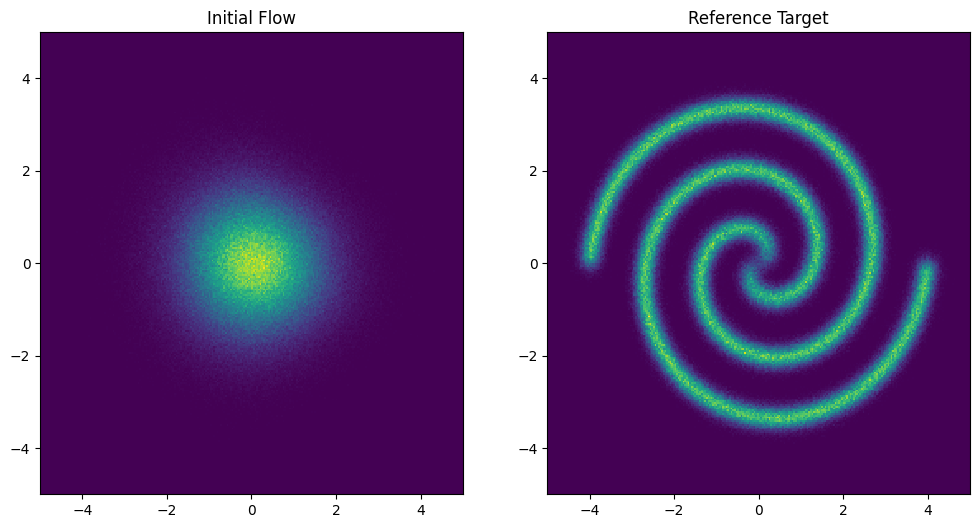

In [12]:
# Compare initial flow distribution with reference distribution
plot_hist(("Initial Flow", FlowDistr(flow)), ("Reference Target", ref))

## Training the Normalizing Flow

### Training Objective

We train the flow by maximizing the log-likelihood of data samples from the
reference distribution. Given samples $x_i \sim \hat{p}_X$, we optimize:

$$\max_{\theta} \mathbb{E}_{x \sim \hat{p}_X}[\log p_{X;\theta}(x)]$$

This is equivalent to minimizing the forward KL divergence:
$$\min_{\theta} D_{KL}(\hat{p}_X \| p_{X;\theta}) = \mathbb{E}_{x \sim \hat{p}_X}[\log \hat{p}_X(x) - \log p_{X;\theta}(x)]$$

Since $\hat{p}_X$ is fixed, we minimize $-\mathbb{E}[\log p_{X;\theta}(x)]$.

### Optimization Details

- **Optimizer**: Adam with learning rate 0.001
- **Batch size**: 16,384 samples per iteration
- **Training length**: 10,000 iterations
- **Gradient scaling**: Used for numerical stability with mixed precision

In [13]:

# Initialize Adam optimizer and gradient scaler for mixed precision training
opt = Adam(lr=0.001, params={"weights": Float32(weights)})
scaler = GradScaler()

# Training hyperparameters
batch_size = 2**14  # 16,384 samples per batch
n = 10_000  # Total training iterations
its = []  # Iteration numbers for logging
losses = []  # Loss values for plotting

# Training loop with progress tracking
iterator = tqdm.tqdm(range(n))
for it in iterator:
    # Update model weights from optimizer
    weights[:] = Float16(opt["weights"])

    # Sample batch from reference distribution
    x = ref.sample(rng, batch_size)
    x = nn.CoopVec(ArrayXf16(x))

    # Compute negative log-likelihood loss
    log_p = flow.log_eval(x)  # Log probability of samples
    loss_kl = -dr.mean(log_p)  # Negative log-likelihood

    # Backpropagation with gradient scaling
    dr.backward(scaler.scale(loss_kl))
    scaler.step(opt)

    # Log progress every 10 iterations
    if (it + 1) % 10 == 0:
        loss = loss_kl.numpy().item()
        losses.append(loss)
        its.append(it)
        iterator.set_postfix({"loss_kl": loss})

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:13<00:00, 727.37it/s, loss_kl=5.28]


## Training Results Analysis

### Loss Interpretation

The loss curve shows the negative log-likelihood, which relates to the KL divergence:

$$\mathcal{L} = -\frac{1}{N}\sum_{i=1}^N \log p_{X;\theta}(x_i) = D_{KL}(\hat{p}_X \| p_{X;\theta}) + H(\hat{p}_X)$$

where $H(\hat{p}_X)$ is the entropy of the reference distribution (constant).

A decreasing loss indicates:
- The flow is learning to assign higher probability to reference samples
- The model distribution $p_{X;\theta}$ is approaching the target $\hat{p}_X$
- Better sample quality and density estimation accuracy

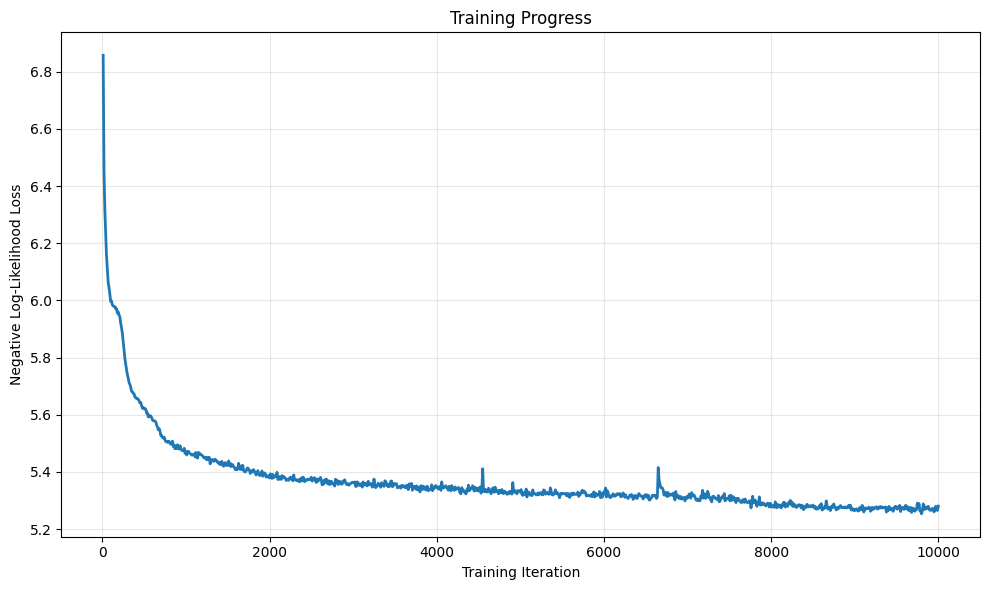

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(its, losses, linewidth=2)
plt.ylabel("Negative Log-Likelihood Loss")
plt.xlabel("Training Iteration")
plt.title("Training Progress")
plt.grid(True, alpha=0.3)
plt.tight_layout()

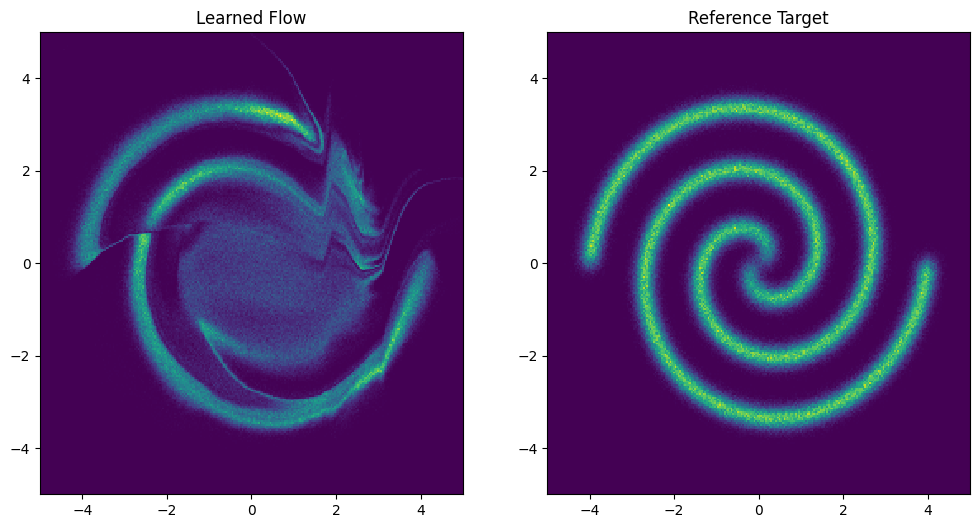

In [15]:
# Compare learned flow distribution with reference distribution
plot_hist(("Learned Flow", FlowDistr(flow)), ("Reference Target", ref))

## Analyzing Learned Transformations

We can examine what the coupling layer networks have learned by visualizing
their outputs. Each coupling network outputs two components:

- **log_s**: Log-scale parameter controlling the expansion/contraction
- **b**: Translation parameter for shifting the distribution

These learned functions show how the flow warps the probability space to
transform the base distribution into the target distribution. Examining
multiple layers reveals the hierarchical nature of the learned representation.

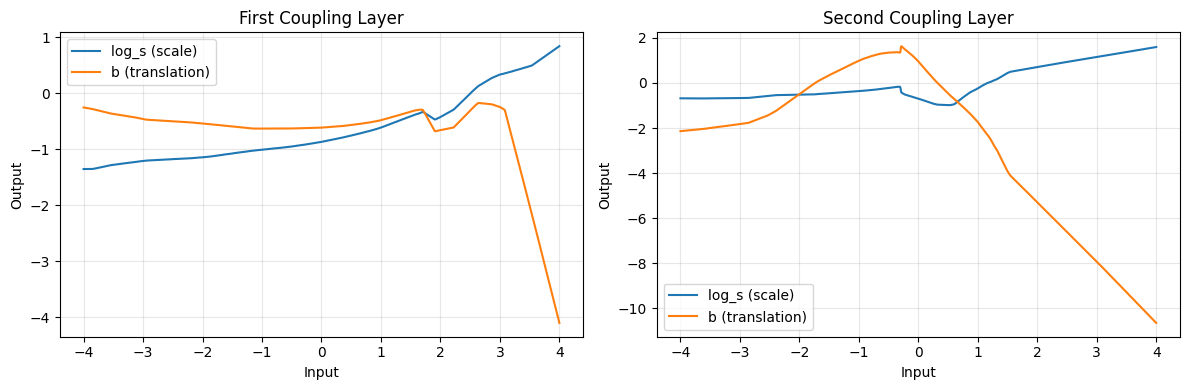

In [16]:
# Visualize first coupling layer's learned transformations
x = dr.linspace(Float16, -4, 4, 1_000)
n = list(flow.layers[0].net(nn.CoopVec(x)))
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(x, n[0], label="log_s (scale)", color="C0")
plt.plot(x, n[1], label="b (translation)", color="C1")
plt.title("First Coupling Layer")
plt.xlabel("Input")
plt.ylabel("Output")
plt.legend()
plt.grid(True, alpha=0.3)

# Visualize second coupling layer's learned transformations
x = dr.linspace(Float16, -4, 4, 1_000)
n = list(flow.layers[2].net(nn.CoopVec(x)))
plt.subplot(1, 2, 2)
plt.plot(x, n[0], label="log_s (scale)", color="C0")
plt.plot(x, n[1], label="b (translation)", color="C1")
plt.title("Second Coupling Layer")
plt.xlabel("Input")
plt.ylabel("Output")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()